## Walt Disney World Resort Areas Part 3

### Segmenting and Clustering WDW Resort areas

Import necessary libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

#### Load and explore the data

In [2]:
resorts=pd.read_csv('wdw_resorts_geo.csv')

In [3]:
resorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
Resort             30 non-null object
Resort Area        30 non-null object
Address            30 non-null object
Number of Rooms    30 non-null object
Latitude           30 non-null float64
Longitude          30 non-null float64
dtypes: float64(2), object(4)
memory usage: 1.5+ KB


In [4]:
resorts['Number of Rooms']=resorts['Number of Rooms'].map(lambda a: a.replace(',', ''))

In [5]:
resorts

,Resort,Resort Area,Address,Number of Rooms,Latitude,Longitude
0,Copper Creek Villas & Cabins at Disney's Wilde...,Magic Kingdom,"901 Timberline Drive Orlando, FL 32830",220,28.40709,-81.57353
1,Disney’s Contemporary Resort,Magic Kingdom,"4600 North World Drive Orlando, FL 32830",655,28.41641,-81.57363
2,Disney’s Grand Floridian Resort,Magic Kingdom,"4401 Floridian Way Orlando, FL 32830",867,28.41081,-81.58814
3,Disney's Polynesian Village Resort,Magic Kingdom,"1600 Seven Seas Drive Orlando, FL 32830",847,28.40580,-81.58399
4,Disney’s Wilderness Lodge,Magic Kingdom,"901 Timberline Drive Orlando, FL 32830",430,28.40709,-81.57353
5,Bay Lake Tower at Disney’s Contemporary Resort,Magic Kingdom,"4600 North World Drive Lake Buena Vista, FL 32830",295,28.41641,-81.57363
6,The Villas at Disney’s Grand Floridian Resort ...,Magic Kingdom,"4401 Floridian Way Orlando, FL 32830",147,28.41081,-81.58814
7,Boulder Ridge Villas at Disney's Wilderness Lodge,Magic Kingdom,"901 Timberline Drive Orlando, FL 32830",136,28.40709,-81.57353
8,Disney’s Fort Wilderness Resort Cabins,Magic Kingdom,"4510 North Fort Wilderness Trail Orlando, FL 3...",409,28.39582,-81.55327
9,Disney’s Beach Club Resort,Epcot,"1800 Epcot Resort Boulevard Lake Buena Vista, ...",583,28.37382,-81.55731


#### Use geopy library to get the latitude and longitude values of Lake Buena Vista, Florida USA.

In order to define an instance of the geocoder, we need to define a user_agent. Agent is named <em>wdw_explorer</em>, as shown below.

In [7]:
address = 'Lake Buena Vista, Florida'

geolocator = Nominatim(user_agent="wdw_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lake Buena Vista, Florida are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Lake Buena Vista, Florida are 28.38034955, -81.5297578369267.


#### Create a map of Lake Buena Vista, FL USA with resorts superimposed on top.

In [8]:
# create map of Lake Buena Vista, FL using latitude and longitude values
map_wdw = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, resort_area, resort in zip(resorts['Latitude'], resorts['Longitude'], 
                                         resorts['Resort Area'], resorts['Resort']):
    label = '{}, {}'.format(resort, resort_area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wdw)  
    
map_wdw

Segment and cluster only the resorts in the Epcot resort area. 

In [9]:
epcot_resorts=resorts[resorts['Resort Area'].str.contains('Epcot')].reset_index(drop=True)
epcot_resorts

,Resort,Resort Area,Address,Number of Rooms,Latitude,Longitude
0,Disney’s Beach Club Resort,Epcot,"1800 Epcot Resort Boulevard Lake Buena Vista, ...",583,28.37382,-81.55731
1,Disney’s BoardWalk Inn,Epcot,"2101 Epcot Resort Boulevard Orlando, FL 32830",378,28.37382,-81.55731
2,Disney’s Yacht Club Resort,Epcot,"1700 Epcot Resort Boulevard Orlando, FL 32830",630,28.37382,-81.55731
3,Dolphin at Walt Disney World,Epcot,"1500 Epcot Resort Boulevard Lake Buena Vista, ...",1509,28.37382,-81.55731
4,Swan at Walt Disney World,Epcot,"1500 Epcot Resort Boulevard Lake Buena Vista, ...",758,28.37382,-81.55731
5,Disney’s Beach Club Villas,Epcot,"1900 Epcot Resort Boulevard Lake Buena Vista, ...",282,28.37382,-81.55731
6,Disney’s BoardWalk Villas,Epcot,"2101 Epcot Resort Boulevard Orlando, FL 32830",532,28.37382,-81.55731
7,Disney's Riviera Resort,Epcot,"1080 Esplanade Ave Lake Buena Vista, FL 32830",489,28.37797,-81.51904
8,Disney’s Caribbean Beach Resort,Epcot,"900 Cayman Way Orlando, FL 32830",1536,28.36202,-81.54264
9,Disney’s Art of Animation Resort,Epcot,"1850 Animation Way Lake Buena Vista, FL 32830",1984,28.35037,-81.54837


In [10]:
epcot_resorts.shape

(11, 6)

#### Visualize resorts in the Epcot area.

First, get latitude and longitude for Epcot.

In [11]:
from geopy.geocoders import TomTom
geolocator = TomTom('')
epcot_address='200 Epcot Center Dr, Orlando, FL 32821'
address, (latitude, longitude) = geolocator.geocode(epcot_address)
print('The Epcot address is ', epcot_address, ', and the coordinates are ', latitude, longitude)

The Epcot address is  200 Epcot Center Dr, Orlando, FL 32821 , and the coordinates are  28.35934 -81.5189


#### Create map of Epcot resort area with markers for Epcot resorts.

In [12]:
# create map of the Epcot area using latitude and longitude values
map_epcot_resorts = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(epcot_resorts['Latitude'], epcot_resorts['Longitude'], epcot_resorts['Resort']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_epcot_resorts)  
    
map_epcot_resorts

### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Explore the first resort in our dataframe.

Get the first resort.

In [14]:
epcot_resorts.loc[0, 'Resort']

'Disney’s Beach Club Resort '

Get the latitude and longitude values for the first resort.

In [15]:
resort_latitude = epcot_resorts.loc[0, 'Latitude'] 
resort_longitude = epcot_resorts.loc[0, 'Longitude']
resort_name = epcot_resorts.loc[0, 'Resort']
print('Latitude and longitude values of {} are {}, {}.'.format(resort_name,
                                                               resort_latitude,
                                                               resort_longitude))

Latitude and longitude values of Disney’s Beach Club Resort  are 28.373820000000002, -81.55731.


#### Now, let's get the top 100 venues that are within a radius of 500 meters of the first resort.

First, let's create the GET request URL.

 Increased radius from 500 to 1000 to try to get more diverse venue results for the different resorts.

In [16]:
LIMIT=100
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    resort_latitude, 
    resort_longitude, 
    radius, 
    LIMIT)

Send the GET request and examine the resutls

In [17]:
results = requests.get(url).json()


From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Disney's Beach Club Resort,Resort,28.371218,-81.556503
1,Cape May Cafe,Buffet,28.371057,-81.556779
2,Disney's Yacht Club Resort,Resort,28.370957,-81.558713
3,Martha's Vineyard Lounge,Hotel Bar,28.371141,-81.557083
4,Beaches & Cream Soda Shop,Ice Cream Shop,28.371274,-81.557120


And how many venues were returned by Foursquare?

In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## 2. Explore resorts in the Epcot area

#### Let's create a function to repeat the same process to all the resorts in the Epcot area.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Resort', 
                  'Resort Latitude', 
                  'Resort Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each resort hotel and create a new dataframe called 'epcot_resort_venues*.

In [22]:
epcot_resort_venues = getNearbyVenues(names=epcot_resorts['Resort'],
                                   latitudes=epcot_resorts['Latitude'],
                                   longitudes=epcot_resorts['Longitude'])

Disney’s Beach Club Resort 
Disney’s BoardWalk Inn 
Disney’s Yacht Club Resort 
Dolphin at Walt Disney World 
 Swan at Walt Disney World 
Disney’s Beach Club Villas 
Disney’s BoardWalk Villas 
Disney's Riviera Resort 
Disney’s Caribbean Beach Resort 
Disney’s Art of Animation Resort 
Disney’s Pop Century Resort 


#### Let's check the size of the resulting dataframe

In [23]:
print(epcot_resort_venues.shape)
epcot_resort_venues.head()

(249, 7)


,Resort,Resort Latitude,Resort Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Disney’s Beach Club Resort,28.37382,-81.55731,Disney's Beach Club Resort,28.371218,-81.556503,Resort
1,Disney’s Beach Club Resort,28.37382,-81.55731,Cape May Cafe,28.371057,-81.556779,Buffet
2,Disney’s Beach Club Resort,28.37382,-81.55731,Beaches & Cream Soda Shop,28.371274,-81.557120,Ice Cream Shop
3,Disney’s Beach Club Resort,28.37382,-81.55731,Martha's Vineyard Lounge,28.371141,-81.557083,Hotel Bar
4,Disney’s Beach Club Resort,28.37382,-81.55731,Disney's Yacht Club Resort,28.370957,-81.558713,Resort


In [24]:
epcot_resort_venues.columns

Index(['Resort', 'Resort Latitude', 'Resort Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

Let's check how many venues were returned for each resort.

In [25]:
epcot_resort_venues.groupby('Resort').count()

,Resort Latitude,Resort Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Resort,,,,,,
Swan at Walt Disney World,19,19,19,19,19,19
Disney's Riviera Resort,33,33,33,33,33,33
Disney’s Art of Animation Resort,28,28,28,28,28,28
Disney’s Beach Club Resort,19,19,19,19,19,19
Disney’s Beach Club Villas,19,19,19,19,19,19
Disney’s BoardWalk Inn,19,19,19,19,19,19
Disney’s BoardWalk Villas,19,19,19,19,19,19
Disney’s Caribbean Beach Resort,36,36,36,36,36,36
Disney’s Pop Century Resort,19,19,19,19,19,19


#### Let's find out how many unique categories can be curated from all the returned venues

In [26]:
print('There are {} uniques categories.'.format(len(epcot_resort_venues['Venue Category'].unique())))

There are 44 uniques categories.


<a id='item3'></a>

## 3. Analyze Epcot resorts

In [27]:
# one hot encoding
epcot_resort_onehot = pd.get_dummies(epcot_resort_venues[['Venue Category']], prefix="", prefix_sep="")

# add resort column back to dataframe
epcot_resort_onehot['Resort'] = epcot_resort_venues['Resort'] 

# move resort column to the first column
col = epcot_resort_onehot['Resort']
epcot_resort_onehot.drop(labels=['Resort'], axis=1,inplace = True)
epcot_resort_onehot.insert(0, 'Resort', col)

epcot_resort_onehot.head()

,Resort,American Restaurant,Arcade,Athletics & Sports,Beach,Bistro,Boat or Ferry,Boutique,Buffet,Bus Station,Bus Stop,Café,Caribbean Restaurant,Coffee Shop,Convenience Store,Fast Food Restaurant,Food,Food Court,Food Truck,General Entertainment,Gift Shop,Golf Course,Gym,Gym / Fitness Center,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Intersection,Lake,Laundromat,Lighthouse,Lounge,Playground,Pool Hall,Rental Car Location,Restaurant,Spa,Steakhouse,Theater,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Tram Station
0,Disney’s Beach Club Resort,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Disney’s Beach Club Resort,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Disney’s Beach Club Resort,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Disney’s Beach Club Resort,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Disney’s Beach Club Resort,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [28]:
epcot_resort_onehot.shape

(249, 44)

#### Next, let's group rows by resort and by taking the mean of the frequency of occurrence of each category

In [29]:
epcot_resort_grouped = epcot_resort_onehot.groupby('Resort').mean().reset_index()
epcot_resort_grouped

,Resort,American Restaurant,Arcade,Athletics & Sports,Beach,Bistro,Boat or Ferry,Boutique,Buffet,Bus Station,Bus Stop,Café,Caribbean Restaurant,Coffee Shop,Convenience Store,Fast Food Restaurant,Food,Food Court,Food Truck,General Entertainment,Gift Shop,Golf Course,Gym,Gym / Fitness Center,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Intersection,Lake,Laundromat,Lighthouse,Lounge,Playground,Pool Hall,Rental Car Location,Restaurant,Spa,Steakhouse,Theater,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Tram Station
0,Swan at Walt Disney World,0.157895,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.105263,0.000000,0.000000,0.000000
1,Disney's Riviera Resort,0.060606,0.030303,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.090909,0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.030303,0.000000,0.030303,0.030303,0.030303,0.060606,0.121212,0.090909,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.030303,0.000000,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000
2,Disney’s Art of Animation Resort,0.000000,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.107143,0.071429,0.178571,0.000000,0.035714,0.035714,0.035714,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Disney’s Beach Club Resort,0.157895,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.105263,0.000000,0.000000,0.000000
4,Disney’s Beach Club Villas,0.157895,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.105263,0.000000,0.000000,0.000000
5,Disney’s BoardWalk Inn,0.157895,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.105263,0.000000,0.000000,0.000000
6,Disney’s BoardWalk Villas,0.157895,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.105263,0.000000,0.000000,0.000000
7,Disney’s Caribbean Beach Resort,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.027778,0.027778,0.055556,0.111111,0.027778,0.027778,0.027778,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138889,0.027778,0.166667,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.027778,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.027778,0.027778,0.027778
8,Disney’s Pop Century Resort,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,

#### Let's confirm the new size

In [30]:
epcot_resort_grouped.shape

(11, 44)

#### Let's print each resort hotel along with the top 5 most common venues

In [31]:
num_top_venues = 5

for hood in epcot_resort_grouped['Resort']:
    print("----"+hood+"----")
    temp = epcot_resort_grouped[epcot_resort_grouped['Resort'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Swan at Walt Disney World ----
                          venue  freq
0           American Restaurant  0.16
1                     Hotel Bar  0.16
2  Theme Park Ride / Attraction  0.11
3                        Lounge  0.05
4                Ice Cream Shop  0.05


----Disney's Riviera Resort ----
                 venue  freq
0            Hotel Bar  0.12
1           Hotel Pool  0.09
2          Bus Station  0.09
3  American Restaurant  0.06
4                Hotel  0.06


----Disney’s Art of Animation Resort ----
        venue  freq
0  Hotel Pool  0.18
1       Hotel  0.11
2    Bus Stop  0.07
3   Hotel Bar  0.07
4  Playground  0.07


----Disney’s Beach Club Resort ----
                          venue  freq
0           American Restaurant  0.16
1                     Hotel Bar  0.16
2  Theme Park Ride / Attraction  0.11
3                        Lounge  0.05
4                Ice Cream Shop  0.05


----Disney’s Beach Club Villas ----
                          venue  freq
0           American 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each resort.

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Resort']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
epcot_resort_venues_sorted = pd.DataFrame(columns=columns)
epcot_resort_venues_sorted['Resort'] = epcot_resort_grouped['Resort']

for ind in np.arange(epcot_resort_grouped.shape[0]):
    epcot_resort_venues_sorted.iloc[ind, 1:] = return_most_common_venues(epcot_resort_grouped.iloc[ind, :], num_top_venues)

epcot_resort_venues_sorted.head()

,Resort,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Swan at Walt Disney World,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
1,Disney's Riviera Resort,Hotel Bar,Bus Station,Hotel Pool,American Restaurant,Hotel,Ice Cream Shop,Arcade,Boat or Ferry,Café,Fast Food Restaurant
2,Disney’s Art of Animation Resort,Hotel Pool,Hotel,Playground,Hotel Bar,Bus Stop,Laundromat,Gift Shop,Intersection,Lake,Food Court
3,Disney’s Beach Club Resort,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
4,Disney’s Beach Club Villas,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach


## 4. Cluster Resorts

Run *k*-means to cluster the resorts.  

C:\Users\Gia\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)


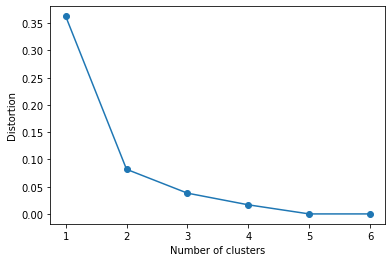

In [35]:
distortions = []
epcot_resort_grouped_clustering = epcot_resort_grouped.drop('Resort', 1)
for i in range(1, 7):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(epcot_resort_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 7), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [36]:
# set number of clusters
kclusters = 3

epcot_resort_grouped_clustering = epcot_resort_grouped.drop('Resort', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(epcot_resort_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[1:10] 

array([2, 1, 0, 0, 0, 0, 1, 1, 0])

In [37]:
epcot_resort_venues_sorted

,Resort,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Swan at Walt Disney World,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
1,Disney's Riviera Resort,Hotel Bar,Bus Station,Hotel Pool,American Restaurant,Hotel,Ice Cream Shop,Arcade,Boat or Ferry,Café,Fast Food Restaurant
2,Disney’s Art of Animation Resort,Hotel Pool,Hotel,Playground,Hotel Bar,Bus Stop,Laundromat,Gift Shop,Intersection,Lake,Food Court
3,Disney’s Beach Club Resort,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
4,Disney’s Beach Club Villas,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
5,Disney’s BoardWalk Inn,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
6,Disney’s BoardWalk Villas,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
7,Disney’s Caribbean Beach Resort,Hotel Pool,Hotel,Bus Stop,Bus Station,Restaurant,Laundromat,Convenience Store,Tourist Information Center,Coffee Shop,Hotel Bar
8,Disney’s Pop Century Resort,Hotel,Hotel Pool,Bus Stop,Food Court,Arcade,Gym / Fitness Center,Hotel Bar,Playground,Laundromat,Lake
9,Disney’s Yacht Club Resort,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each resort.

In [38]:
epcot_resort_venues_sorted.shape

(11, 11)

In [39]:
epcot_resorts.shape

(11, 6)

In [40]:
epcot_resort_venues_sorted.head()

,Resort,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Swan at Walt Disney World,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
1,Disney's Riviera Resort,Hotel Bar,Bus Station,Hotel Pool,American Restaurant,Hotel,Ice Cream Shop,Arcade,Boat or Ferry,Café,Fast Food Restaurant
2,Disney’s Art of Animation Resort,Hotel Pool,Hotel,Playground,Hotel Bar,Bus Stop,Laundromat,Gift Shop,Intersection,Lake,Food Court
3,Disney’s Beach Club Resort,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
4,Disney’s Beach Club Villas,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach


In [308]:
#epcot_resort_venues_sorted=epcot_resort_venues_sorted.drop(['Cluster Labels'], axis=1)


In [41]:
# add clustering label
epcot_resort_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

epcot_resort_merged = epcot_resorts
epcot_resort_merged.set_index('Resort')

# merge venues_sorted with epcot_resorts to add latitude/longitude for each resort hotel
epcot_resort_merged = epcot_resort_merged.join(epcot_resort_venues_sorted.set_index('Resort'), on='Resort', how='right')

epcot_resort_merged.head() # check the last columns!

,Resort,Resort Area,Address,Number of Rooms,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Disney’s Beach Club Resort,Epcot,"1800 Epcot Resort Boulevard Lake Buena Vista, ...",583,28.37382,-81.55731,0,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
1,Disney’s BoardWalk Inn,Epcot,"2101 Epcot Resort Boulevard Orlando, FL 32830",378,28.37382,-81.55731,0,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
2,Disney’s Yacht Club Resort,Epcot,"1700 Epcot Resort Boulevard Orlando, FL 32830",630,28.37382,-81.55731,0,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
3,Dolphin at Walt Disney World,Epcot,"1500 Epcot Resort Boulevard Lake Buena Vista, ...",1509,28.37382,-81.55731,0,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
4,Swan at Walt Disney World,Epcot,"1500 Epcot Resort Boulevard Lake Buena Vista, ...",758,28.37382,-81.55731,0,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach


Finally, let's visualize the resulting clusters

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(epcot_resort_merged['Latitude'], epcot_resort_merged['Longitude'], 
                                  epcot_resort_merged['Resort'], epcot_resort_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [43]:
c1=epcot_resort_merged.loc[epcot_resort_merged['Cluster Labels'] == 0, 
                        epcot_resort_merged.columns[[0] + list(range(3, epcot_resort_merged.shape[1]))]]
c1['Number of Rooms']=c1['Number of Rooms'].astype(int)
print('Total number of rooms for cluster 1 is ', str(c1['Number of Rooms'].sum()))
c1=c1.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)
c1

Total number of rooms for cluster 1 is  4672


,Resort,Number of Rooms,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Disney’s Beach Club Resort,583,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
1,Disney’s BoardWalk Inn,378,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
2,Disney’s Yacht Club Resort,630,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
3,Dolphin at Walt Disney World,1509,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
4,Swan at Walt Disney World,758,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
5,Disney’s Beach Club Villas,282,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach
6,Disney’s BoardWalk Villas,532,American Restaurant,Hotel Bar,Theme Park Ride / Attraction,Buffet,Convenience Store,Ice Cream Shop,Laundromat,Lounge,Lighthouse,Beach


#### Cluster 2

In [44]:
c2=epcot_resort_merged.loc[epcot_resort_merged['Cluster Labels'] == 1, 
                        epcot_resort_merged.columns[[0] + list(range(3, epcot_resort_merged.shape[1]))]]
c2['Number of Rooms']=c2['Number of Rooms'].astype(int)
print('Total number of rooms for cluster 2 is ', str(c2['Number of Rooms'].sum()))
c2=c2.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)
c2

Total number of rooms for cluster 2 is  6400


,Resort,Number of Rooms,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Disney’s Caribbean Beach Resort,1536,Hotel Pool,Hotel,Bus Stop,Bus Station,Restaurant,Laundromat,Convenience Store,Tourist Information Center,Coffee Shop,Hotel Bar
9,Disney’s Art of Animation Resort,1984,Hotel Pool,Hotel,Playground,Hotel Bar,Bus Stop,Laundromat,Gift Shop,Intersection,Lake,Food Court
10,Disney’s Pop Century Resort,2880,Hotel,Hotel Pool,Bus Stop,Food Court,Arcade,Gym / Fitness Center,Hotel Bar,Playground,Laundromat,Lake


#### Cluster 3

In [45]:
c3=epcot_resort_merged.loc[epcot_resort_merged['Cluster Labels'] == 2, 
                        epcot_resort_merged.columns[[0] + list(range(3, epcot_resort_merged.shape[1]))]]
c3['Number of Rooms']=c3['Number of Rooms'].astype(int)
print('Total number of rooms for cluster 3 is ', str(c3['Number of Rooms'].sum()))
c3=c3.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)
c3

Total number of rooms for cluster 3 is  489


,Resort,Number of Rooms,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Disney's Riviera Resort,489,Hotel Bar,Bus Station,Hotel Pool,American Restaurant,Hotel,Ice Cream Shop,Arcade,Boat or Ferry,Café,Fast Food Restaurant


#### Cluster 4

In [ ]:
c4=epcot_resort_merged.loc[epcot_resort_merged['Cluster Labels'] == 3, 
                        epcot_resort_merged.columns[[0] + list(range(3, epcot_resort_merged.shape[1]))]]
c4['Number of Rooms']=c4['Number of Rooms'].astype(int)
print('Total number of rooms for cluster 4 is ', str(c4['Number of Rooms'].sum()))
c4

#### Cluster 5

In [ ]:
c5=epcot_resort_merged.loc[epcot_resort_merged['Cluster Labels'] == 4, 
                        epcot_resort_merged.columns[[0] + list(range(3, epcot_resort_merged.shape[1]))]]
c5['Number of Rooms']=c5['Number of Rooms'].astype(int)
print('Total number of rooms for cluster 5 is ', str(c5['Number of Rooms'].sum()))
c5